# Portfolio Analysis of Gaming sector

### Stocks under observation:

    - Activision Blizzard (NYSE:ATVI)
    - Tencent Holdings (NYSE:TCEHY)
    - Take-Two Interactive (NYSE:TTWO)
    - Electronic Arts (NYSE:EA)
    - Huya (NYSE:HUYA)
    - Nintendo Co. Ltd. (NYSE:NTDOY)


In [11]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
import scipy.optimize as sco
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pulling stock data 

In [12]:
gaming = ['ATVI', 'TCEHY', 'TTWO', 'EA','HUYA', 'NTDOY' ]
data = pd.DataFrame()
for i in range(len(gaming)):
    
    df = wb.DataReader(gaming[i], data_source='yahoo', start='2019-1-1', end = '2020-5-1')
    df['stock'] = gaming[i]
    data = data.append(df[['Adj Close', 'stock']])

table = data.pivot(columns='stock')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,ATVI,EA,HUYA,NTDOY,TCEHY,TTWO
Date,,,,,,
2019-01-02,46.350380,80.370003,15.770000,32.626484,39.296059,104.010002
2019-01-03,44.704514,78.709999,15.670000,32.354027,38.182125,99.150002
2019-01-04,46.488358,84.419998,17.110001,32.743252,40.400047,101.699997
2019-01-07,47.799141,87.589996,18.500000,33.482769,40.678535,104.410004
2019-01-08,49.247898,89.019997,18.139999,33.803879,40.539291,107.919998


Text(0, 0.5, 'price in $')

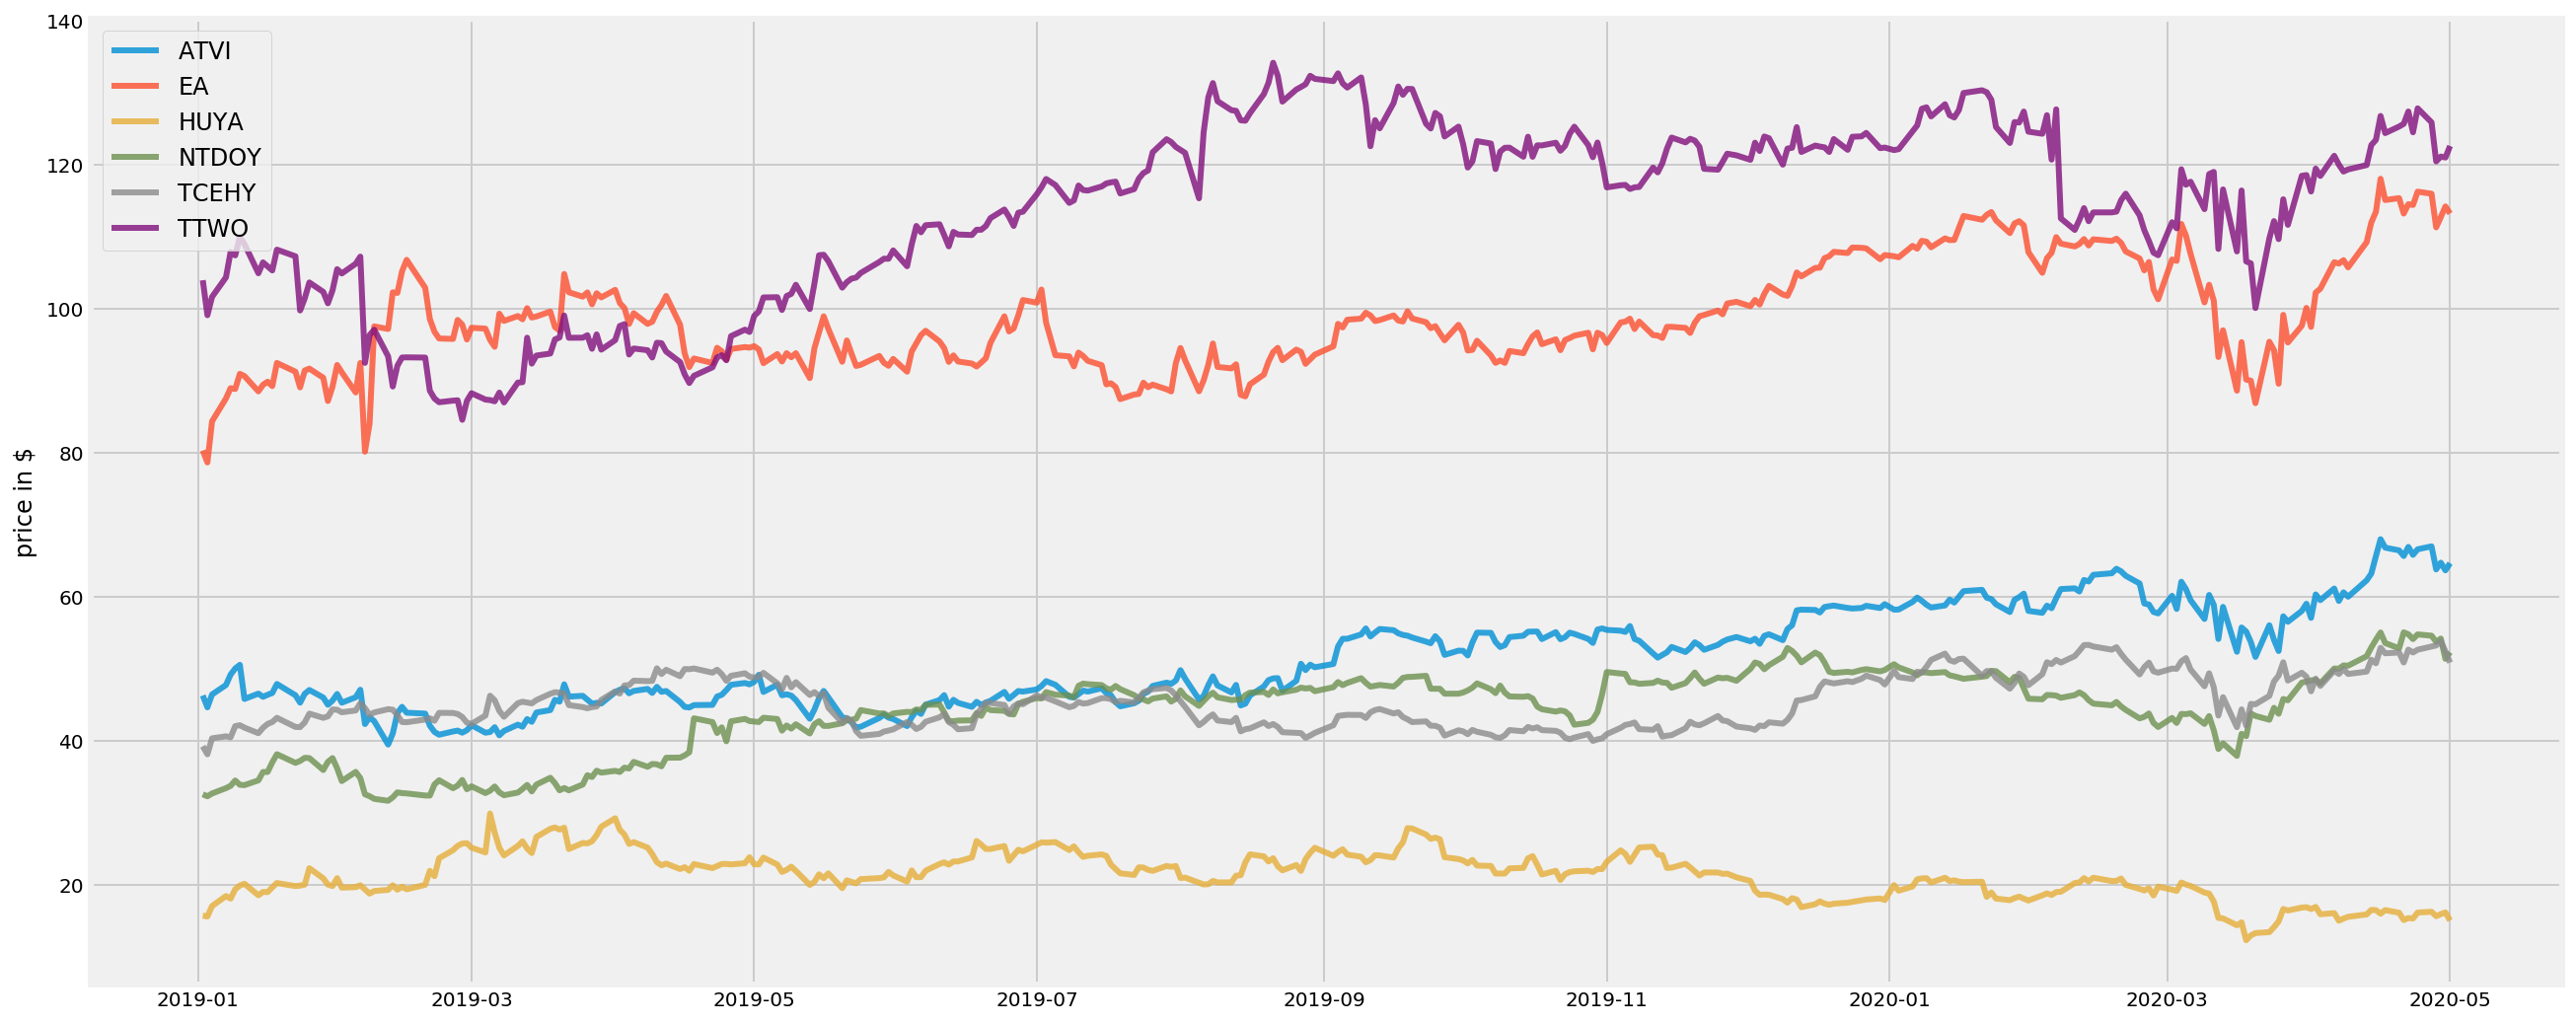

In [13]:
plt.figure(figsize=(20, 9))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

### Simple returns

Text(0, 0.5, 'daily returns')

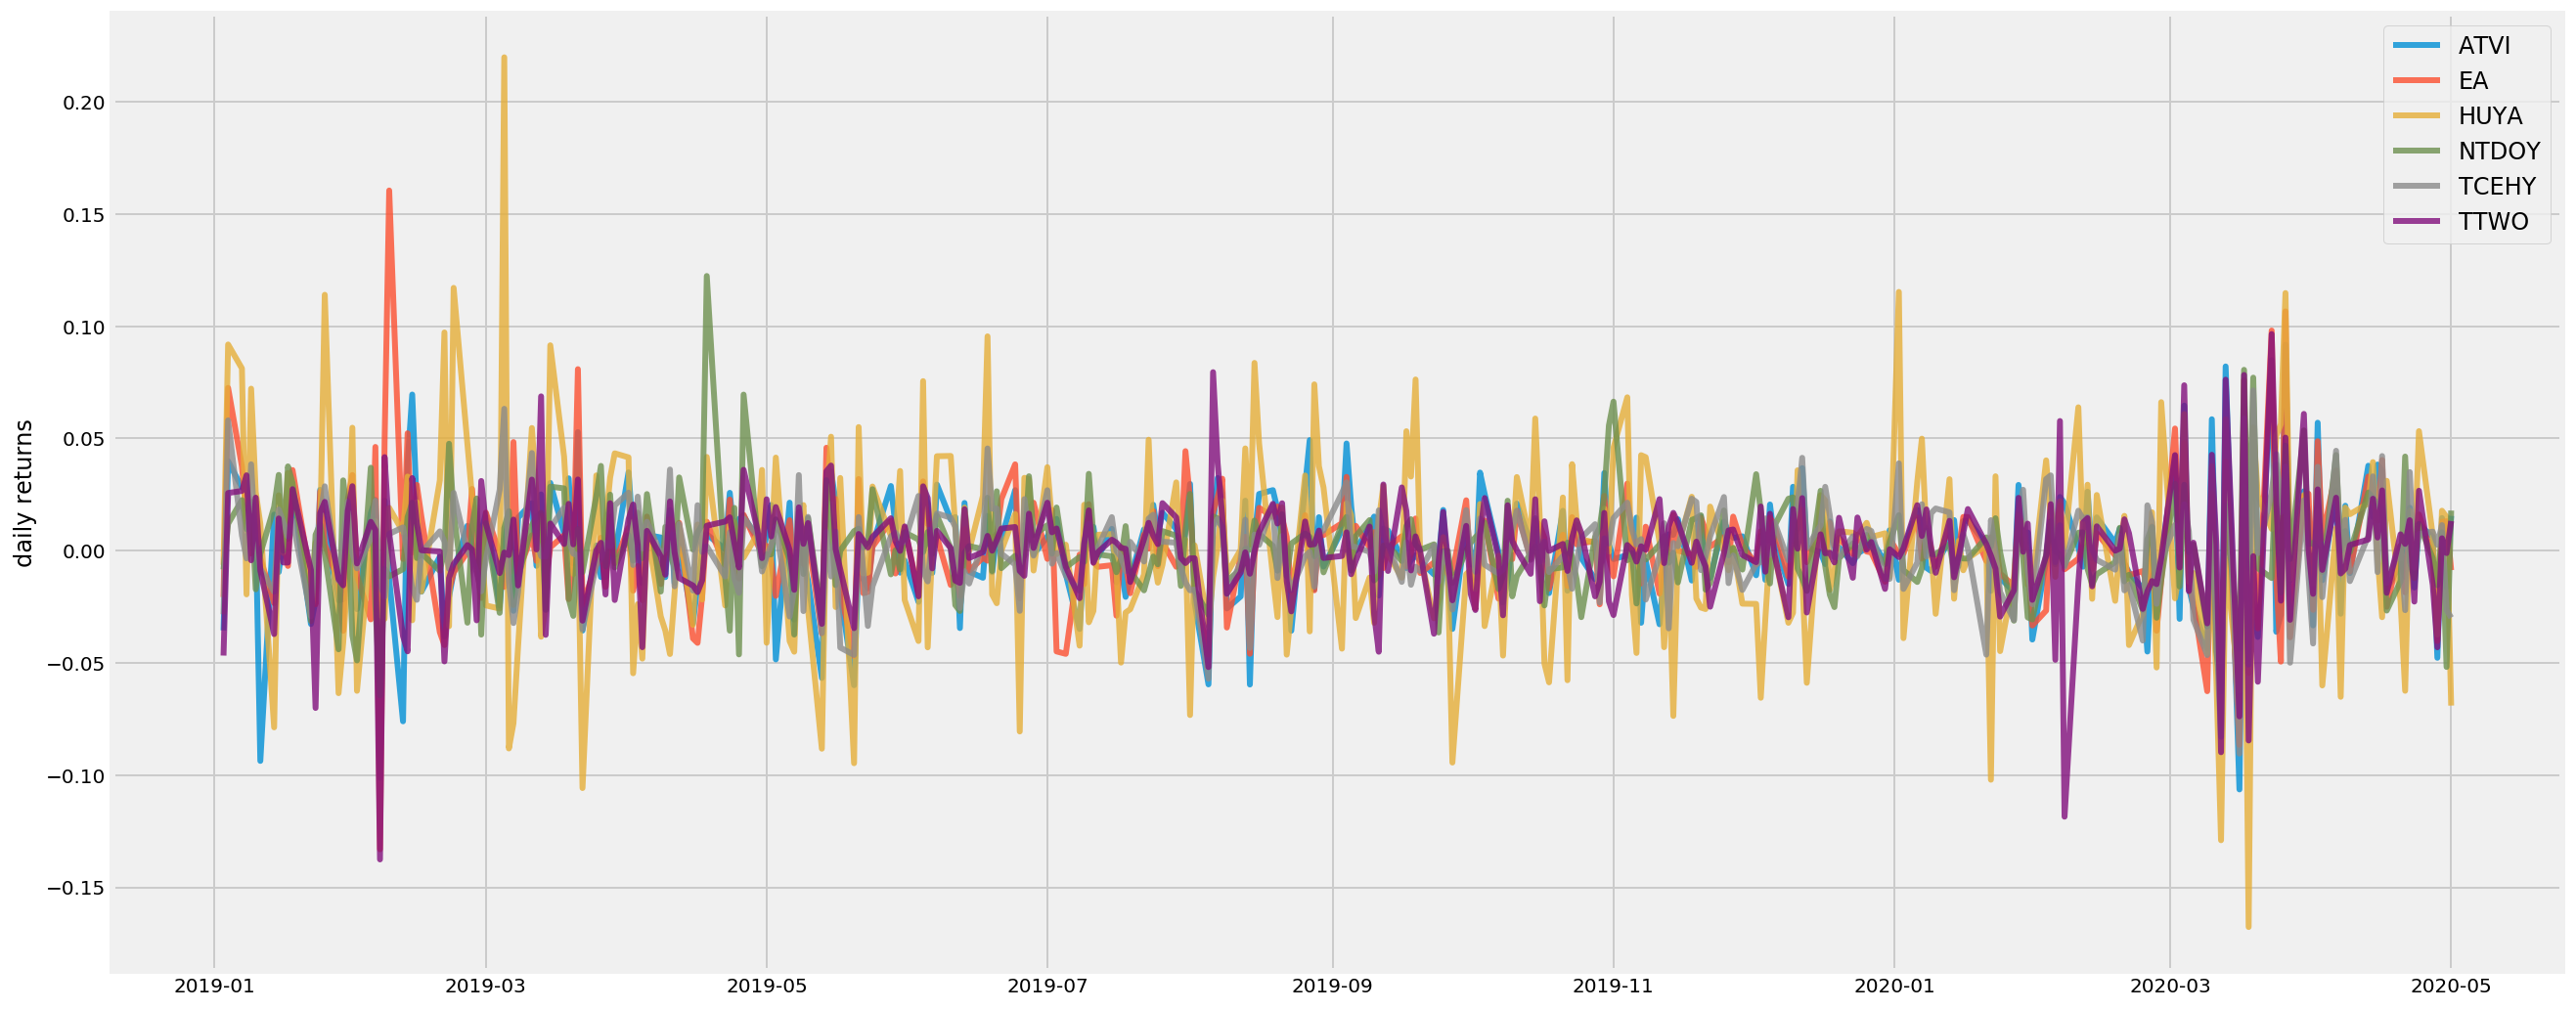

In [14]:
returns = table.pct_change()
plt.figure(figsize=(20, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

### log returns

Text(0, 0.5, 'daily log returns')

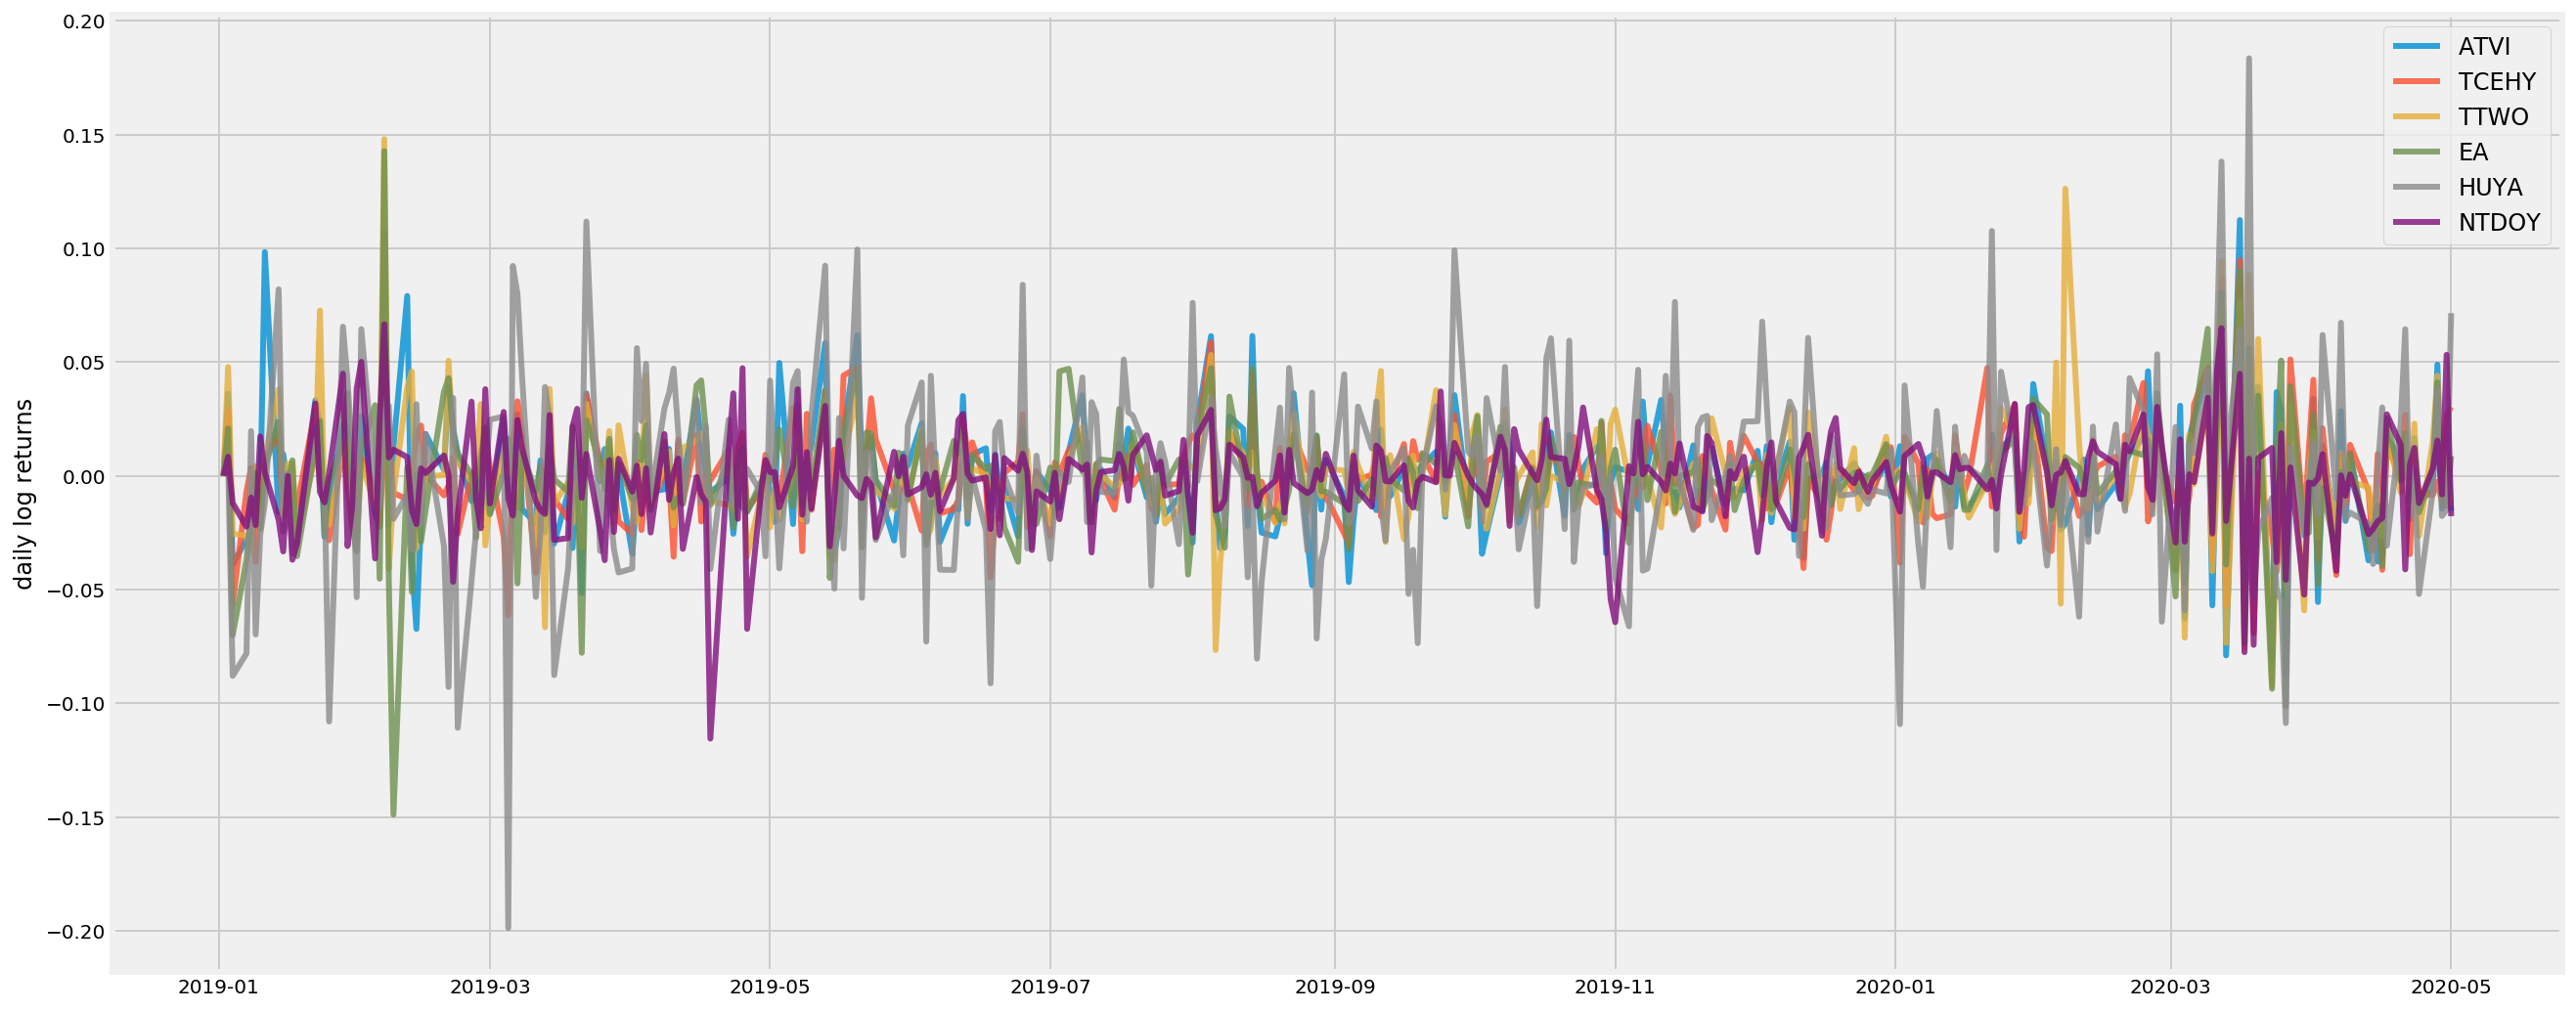

In [15]:
log = pd.DataFrame(columns = gaming, index = table.index)

for i in range(len(gaming)):
    log_list = []
    for j in range(len(table[gaming[i]])):
        if(j+1<len(table[gaming[i]])):
            log_returns =  np.log(table[gaming[i]][j]) - np.log(table[gaming[i]][j+1])
            log_list.append(log_returns)
            

        else:
            None
    log_list.insert(0, 0)   
    log[gaming[i]] = log_list


plt.figure(figsize=(20, 9))
for c in log.columns.values:
     plt.plot(log.index, log[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily log returns')


### Normalization to 100

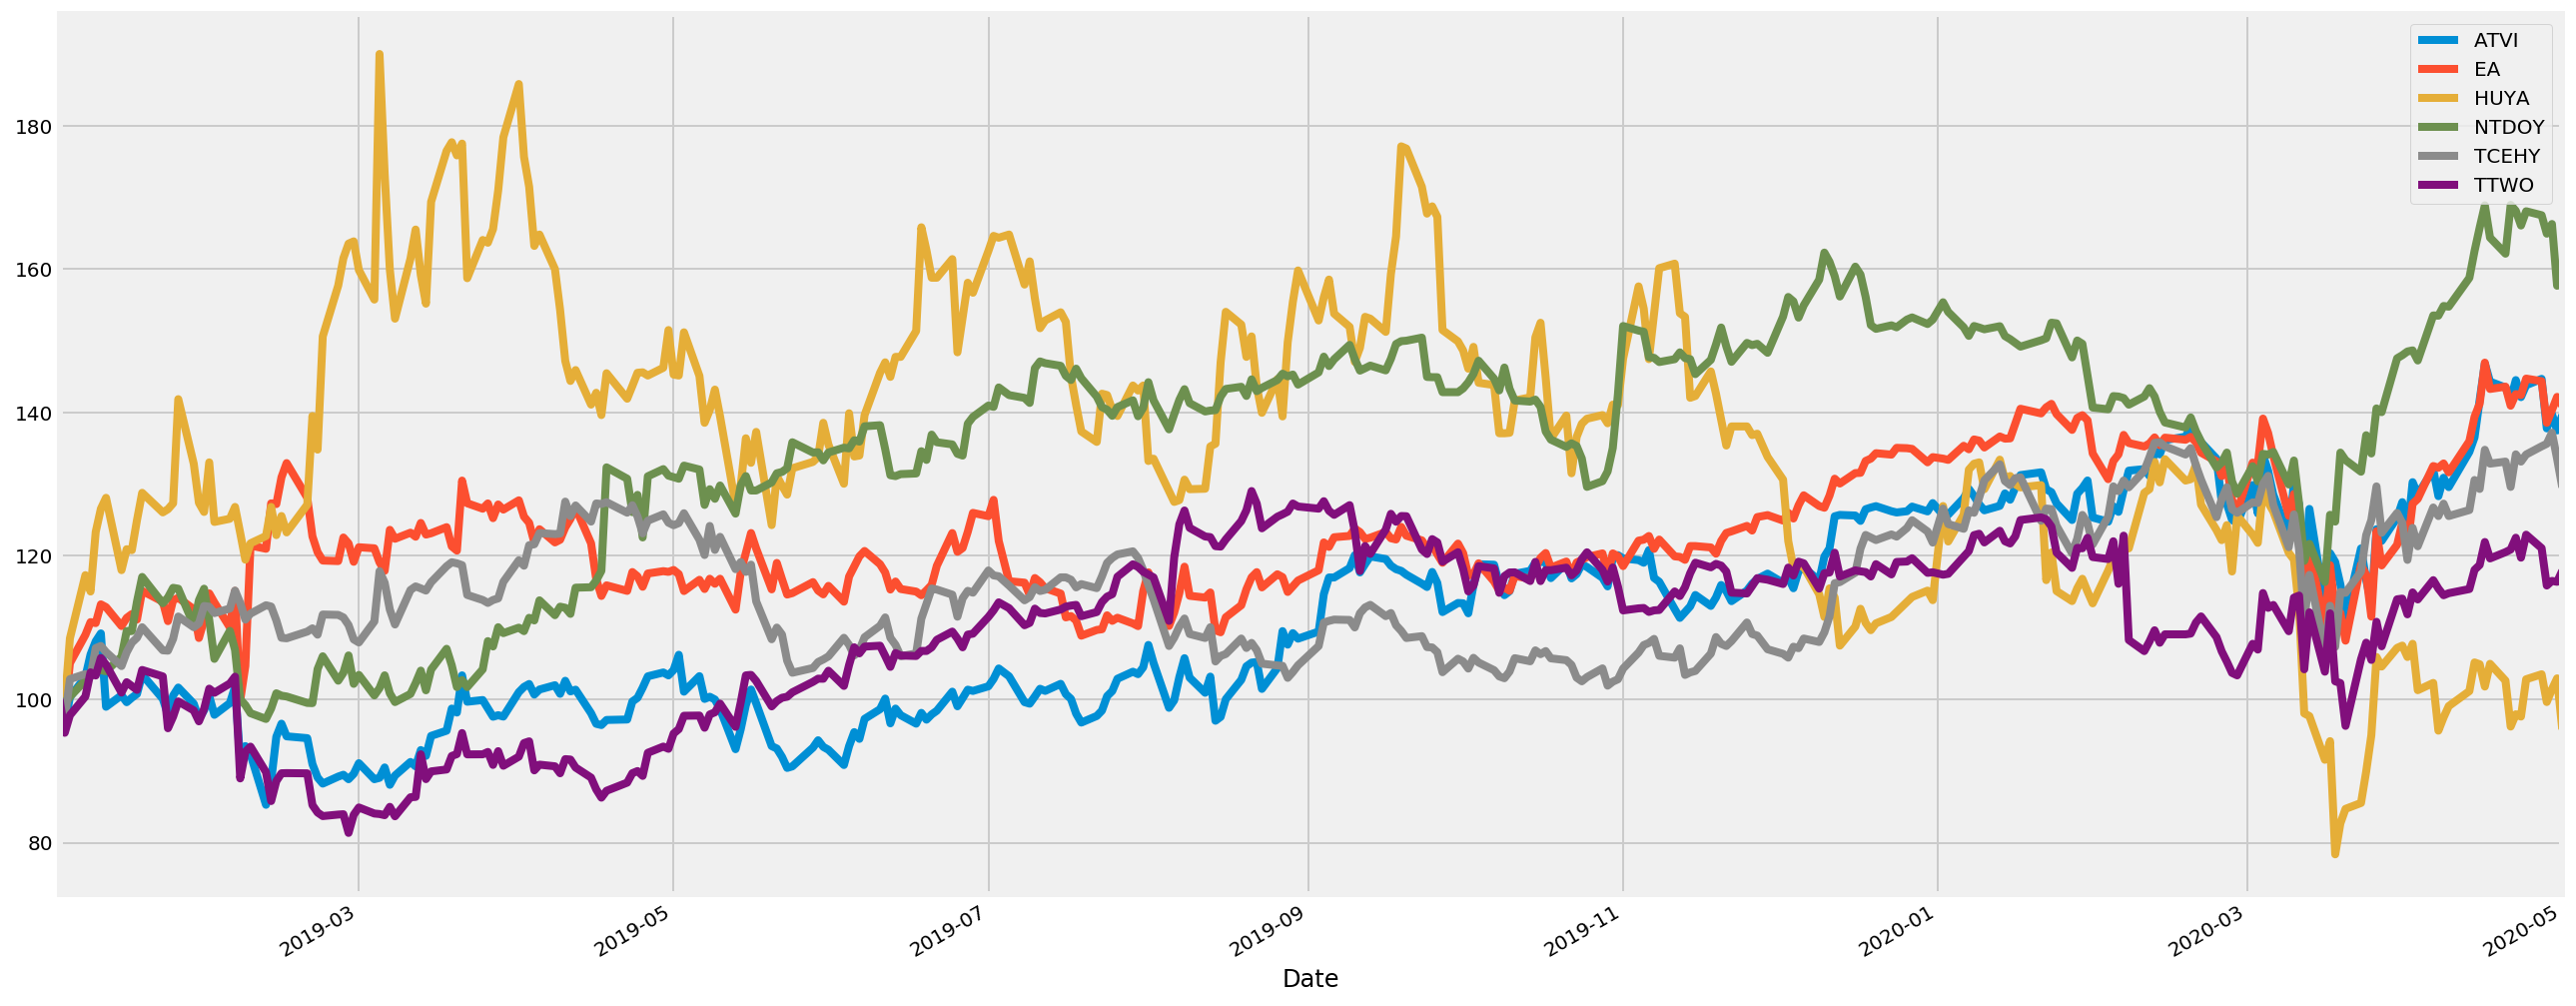

In [16]:
(table/table.iloc[0] * 100).plot(figsize = (20,9))
plt.show()

In [17]:
log.mean()*252

ATVI    -0.250381
TCEHY   -0.194248
TTWO    -0.123636
EA      -0.257350
HUYA     0.032065
NTDOY   -0.354764
dtype: float64

In [18]:
log.std()*252**0.5

ATVI     0.402747
TCEHY    0.329887
TTWO     0.400764
EA       0.401837
HUYA     0.652982
NTDOY    0.332568
dtype: float64

In [19]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return(results, weights_record)

mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.0073

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.36
Annualised Volatility: 0.28


            ATVI     EA  HUYA  NTDOY  TCEHY  TTWO
allocation  5.08  15.13  0.73  58.29  19.52  1.25
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.31
Annualised Volatility: 0.27


            ATVI     EA  HUYA  NTDOY  TCEHY   TTWO
allocation  6.13  11.57  0.17  32.45   34.3  15.38


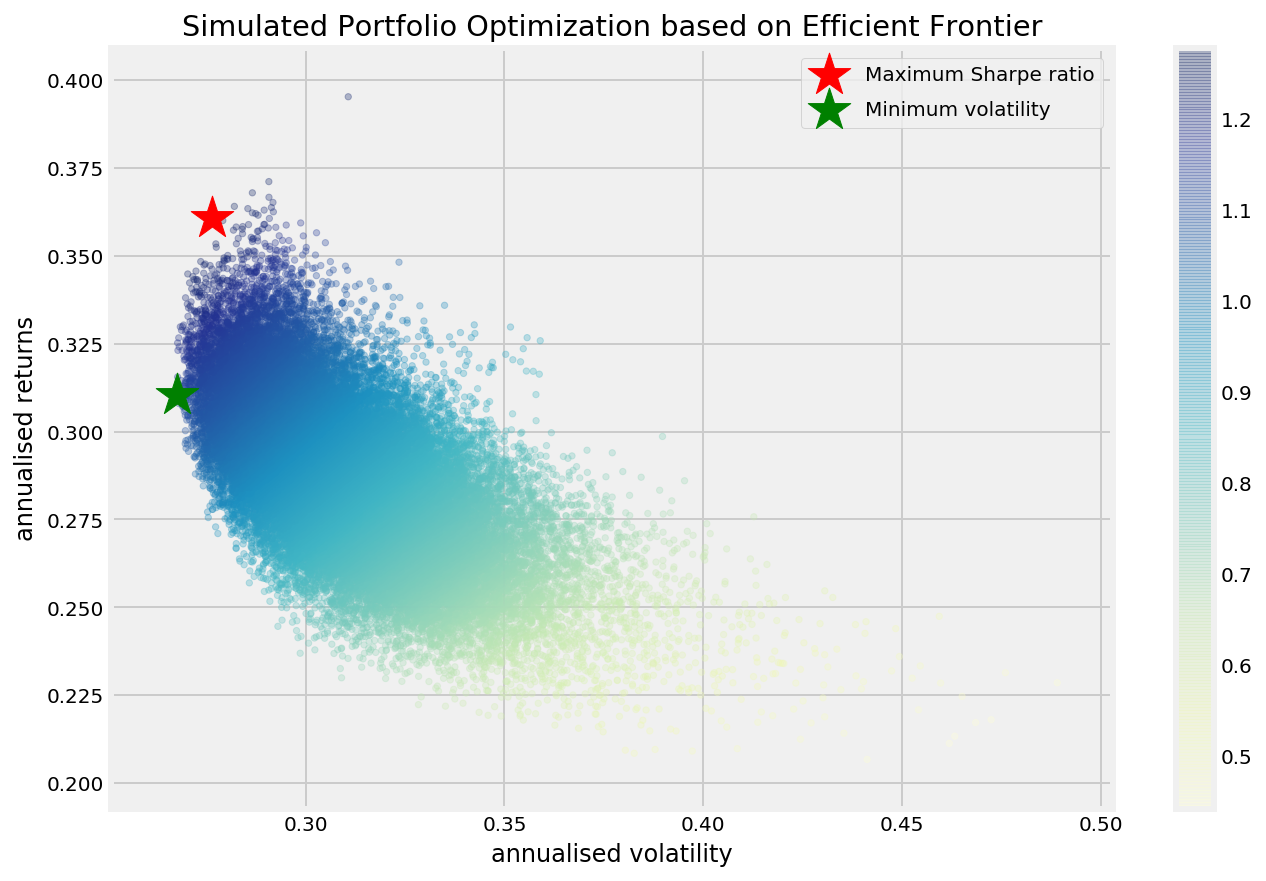

In [20]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)